In [5]:
# For file reading
import pickle,os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# For Deep learning
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image
import keras, cv2, h5py, json, math, argparse, dataSetGeneration
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout,Flatten,Conv2D,MaxPooling2D,Input,Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import losses, regularizers
from glob import glob
import keras.backend as K


In [6]:
# Extract features and labels from files
def getData(fileName):
    pkl_file = open(fileName,'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    x = data[0]
    y = data[1]
    return x,y

In [7]:
# Generator for large data set of training examples
def dataGenerator(batch_size):
    imageSet = glob("./data_small/train/*.p")

    n = 0
    while(True):
        pkl_file = open(imageSet[n % 5],'rb')
        data = pickle.load(pkl_file)                
        pkl_file.close()

        length_dataset = data[0].shape[0]
        features = np.array_split(data[0], math.ceil(length_dataset/batch_size), axis=0)
        labels = np.array_split(data[1], math.ceil(length_dataset/batch_size), axis=0)
        for batch_feature, batch_label in zip(features,labels):
            if (batch_feature.shape[0] == batch_size):
                x_train = batch_feature.astype('float32') / 255
                y_train = (batch_label.astype('float32'))/32# + 32) / 64
                yield x_train, y_train
            else: 
                n += 1
                break 

In [9]:
epochs = 12
batch_size = 16

# Load validate and test data
x_valid,y_valid = getData('data_small/valid1k.p')
x_valid = x_valid.astype('float32') / 255
y_valid = (y_valid.astype('float32'))/32
x_test,y_test = getData('data_small/test1k.p')
x_test = x_test.astype('float32') / 255
y_test = (y_test.astype('float32'))/64

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 64)      1216      
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_10 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_11 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
block_POOL1 (MaxPooling2D)   (None, 64, 64, 64)        0         
__________

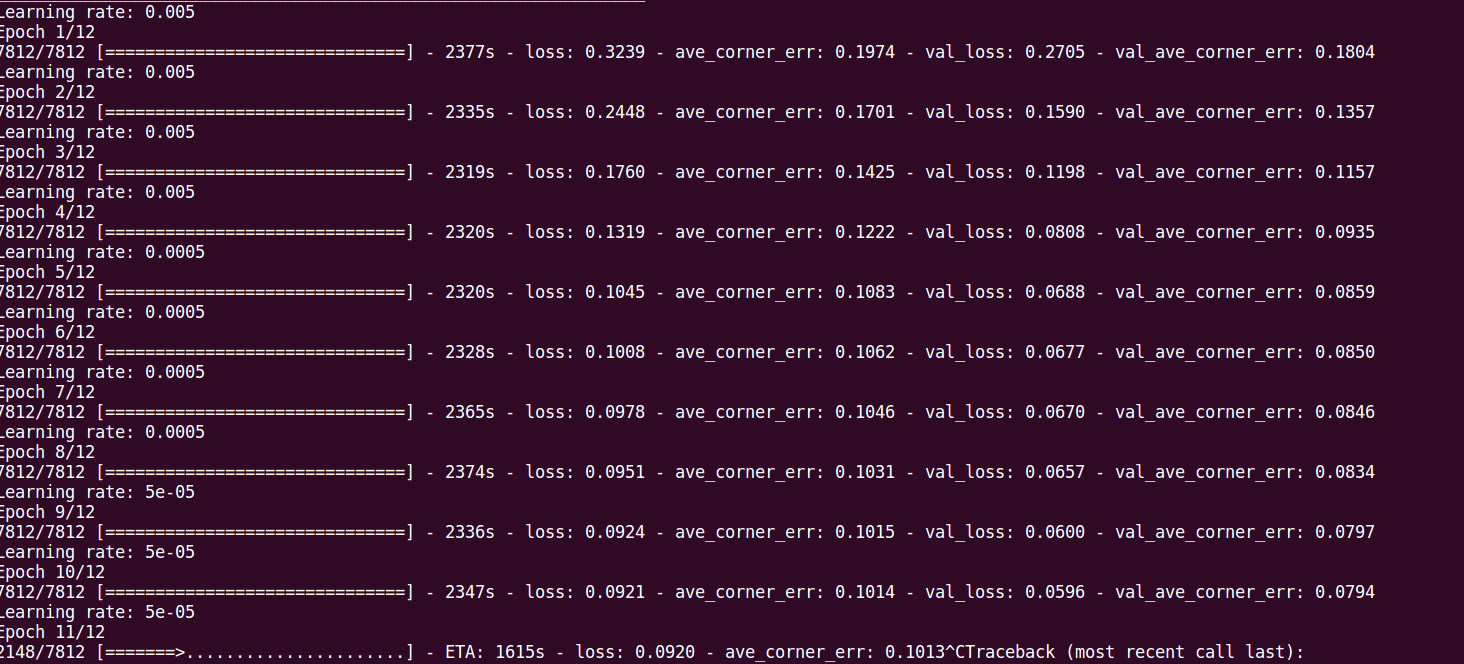

In [9]:


# VGG-net: https://keras.io/getting-started/sequential-model-guide/
model = Sequential()
model.add(Conv2D(64,(3,3), padding='same',input_shape=(128,128,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='block_POOL1'))

model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(8))

model.summary()
Image("notebook_images/training.png")

In [4]:
# Euclidean Distance
def ave_corner_err(y_true, y_pred):
    return K.mean(K.sqrt(K.sum(K.square(K.reshape(y_pred,(-1,4,2)) - K.reshape(y_true,(-1,4,2))), axis=-1, keepdims=True)))

In [ ]:
# homographyNet Training 
model.compile(optimizer=SGD(lr=0.005, momentum=0.9), loss='mse', metrics=[ave_corner_err])
model_json = model.to_json()
with open("homography_model_compiled.json","w") as json_file:
    json_file.write(model_json)                        # Save model architecture

# Reduce learning rate per 4 epochs
lrate = LearningRateScheduler(step_decay)
# Save weights every epoch
checkpointer = ModelCheckpoint(filepath="./tmp/weights.{epoch:02d}.h5",verbose=0, period=1, save_weights_only=True)
# Train model
model.fit_generator(dataGenerator(batch_size=batch_size), steps_per_epoch=100,epochs=epochs, validation_data=(x_valid,y_valid), callbacks=[checkpointer,lrate])

model.save_weights('homography_model_weights.h5')  # Save model weights

In [9]:
# Evaluation
x_test,y_test = getData('data_small/test1k.p')
x_test = x_test.astype('float32') / 255
y_test = (y_test.astype('float32'))/64

json_file = open('homography_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.compile(optimizer=SGD(lr=0.005, momentum=0.9), loss='mse', metrics=[ave_corner_err])
model.load_weights('homography_weights.h5')

score = model.evaluate(x_test, y_test, batch_size=20)

print("\nloss:",score[0])
print("\nmean average corner error:", score[1] * 64)

100/100 [==============================] - 2s     

loss: 0.0965074360371

mean average corner error: 24.4682056427


In [11]:
def plotImage_with_draw(image,corners,title):
    for i,point_corners in enumerate(corners):
        if(i == 0):
            cv2.polylines(image, np.int32([[point_corners]]),True,(0,255,0),2)
        if(i == 1):
            cv2.polylines(image, np.int32([[point_corners]]),True,(255,0,0),2)
    plotImage(image,title)

def plotImage(image,title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

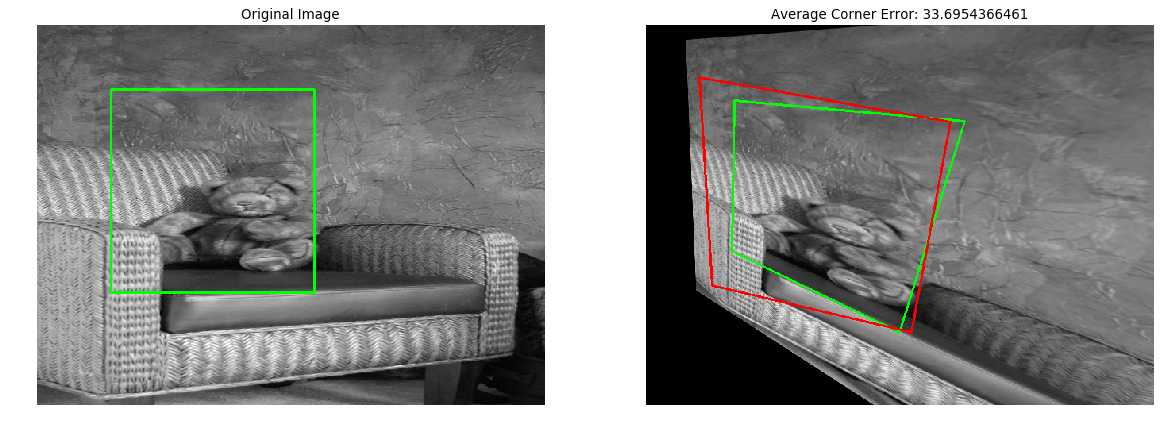

In [14]:
json_file = open('homography_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('homography_weights.h5')

images_file = glob("./sample_images/*.jpg")

# Get parameters of image data
patches,labels,data = dataSetGeneration.createData(images_file[3],'test')

# Predict points using trained model
x_resized = np.array([cv2.resize(patches,(128,128))])
H_4point = model.predict(x_resized/255) * 64
perturbedPoints = np.array_split(np.array(np.squeeze(H_4point,axis=0)),4)\
                + data[4]

# Average Corner Error
ave_cor_err = np.mean(np.sqrt(np.sum(np.square(perturbedPoints - data[5]),axis=-1)))

# Plotting
image1 = data[0].copy()
image_copy1 = cv2.cvtColor(image1,cv2.COLOR_GRAY2RGB)
image2 = data[1].copy()
image_copy2 = cv2.cvtColor(image2,cv2.COLOR_GRAY2RGB)

# Bigger images
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(121)
plotImage_with_draw(image_copy1,[data[4]],'Original Image')
plt.subplot(122)
title_perturbed = 'Average Corner Error: ' + str(ave_cor_err)
plotImage_with_draw(image_copy2,[data[5],perturbedPoints],title_perturbed)
plt.show()